<a href="https://colab.research.google.com/github/Lightning-Nemesis/CSE572_DataMining_Assignment1/blob/main/HW2_Task1_Titanic_Data_Science_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

## Acquire data

The Python Pandas packages helps us work with our datasets. We start by acquiring the training and testing datasets into Pandas DataFrames. We also combine these datasets to run certain operations on both datasets together.

In [3]:
train_df = pd.read_csv('/content/sample_data/train.csv')
test_df = pd.read_csv('/content/sample_data/test.csv')
combine = [train_df, test_df]

## Wrangle data

We have collected several assumptions and decisions regarding our datasets and solution requirements. So far we did not have to change a single feature or value to arrive at these. Let us now execute our decisions and assumptions for correcting, creating, and completing goals.

### Correcting by dropping features

This is a good starting goal to execute. By dropping features we are dealing with fewer data points. Speeds up our notebook and eases the analysis.

Based on our assumptions and decisions we want to drop the Cabin (correcting #2) and Ticket (correcting #1) features.

Note that where applicable we perform operations on both training and testing datasets together to stay consistent.

In [4]:
train_df.Ticket.nunique()

681

In [5]:
train_df.Cabin.nunique()
train_df.Cabin.isna().sum()

687

In [6]:
train_df.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [7]:
cabin_df = train_df.copy()
cabin_df.Cabin = cabin_df.Cabin.str[0]
cabin_df.Cabin.value_counts()

,count
Cabin,
C,59
B,47
D,33
E,32
A,15
F,13
G,4
T,1


In [8]:
cabin_df[['Cabin','Survived']].groupby(['Cabin'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Cabin,Survived
3,D,0.757576
4,E,0.750000
1,B,0.744681
5,F,0.615385
2,C,0.593220
6,G,0.500000
0,A,0.466667
7,T,0.000000


In [9]:
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

# train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
# test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)

train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

combine = [train_df, test_df]

"After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape

Before (891, 12) (418, 11) (891, 12) (418, 11)


('After', (891, 11), (418, 10), (891, 11), (418, 10))

### Creating new feature extracting from existing

We want to analyze if Name feature can be engineered to extract titles and test correlation between titles and survival, before dropping Name and PassengerId features.

In the following code we extract Title feature using regular expressions. The RegEx pattern `(\w+\.)` matches the first word which ends with a dot character within Name feature. The `expand=False` flag returns a DataFrame.

**Observations.**

When we plot Title, Age, and Survived, we note the following observations.

- Most titles band Age groups accurately. For example: Master title has Age mean of 5 years.
- Survival among Title Age bands varies slightly.
- Certain titles mostly survived (Mme, Lady, Sir) or did not (Don, Rev, Jonkheer).

**Decision.**

- We decide to retain the new Title feature for model training.

In [10]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


We can replace many titles with a more common name or classify them as `Rare`.

In [11]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


We can convert the categorical titles to ordinal.

In [12]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S,1


Now we can safely drop the Name feature from training and testing datasets. We also do not need the PassengerId feature in the training dataset.

In [13]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 10), (418, 10))

In [14]:
### Doing Label EncodingCabin Section
for dataset in combine:
  dataset['Cabin_section'] = dataset['Cabin'].str[0]

cabin_mapping = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F":6, "G":7,"T":0}
for dataset in combine:
    dataset['Cabin_section'] = dataset['Cabin_section'].map(cabin_mapping)
    dataset['Cabin_section'] = dataset['Cabin_section'].fillna(0)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Cabin_section
0,0,3,male,22.0,1,0,7.2500,NaN,S,1,0.0
1,1,1,female,38.0,1,0,71.2833,C85,C,3,3.0
2,1,3,female,26.0,0,0,7.9250,NaN,S,2,0.0
3,1,1,female,35.0,1,0,53.1000,C123,S,3,3.0
4,0,3,male,35.0,0,0,8.0500,NaN,S,1,0.0


In [15]:
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 10), (418, 10))

### Converting a categorical feature

Now we can convert features which contain strings to numerical values. This is required by most model algorithms. Doing so will also help us in achieving the feature completing goal.

Let us start by converting Sex feature to a new feature called Gender where female=1 and male=0.

In [16]:
train_df.Sex.isna().sum()

0

In [17]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Cabin_section
0,0,3,0,22.0,1,0,7.2500,S,1,0.0
1,1,1,1,38.0,1,0,71.2833,C,3,3.0
2,1,3,1,26.0,0,0,7.9250,S,2,0.0
3,1,1,1,35.0,1,0,53.1000,S,3,3.0
4,0,3,0,35.0,0,0,8.0500,S,1,0.0


### Completing a numerical continuous feature

Now we should start estimating and completing features with missing or null values. We will first do this for the Age feature.

We can consider three methods to complete a numerical continuous feature.

1. A simple way is to generate random numbers between mean and [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation).

2. More accurate way of guessing missing values is to use other correlated features. In our case we note correlation among Age, Gender, and Pclass. Guess Age values using [median](https://en.wikipedia.org/wiki/Median) values for Age across sets of Pclass and Gender feature combinations. So, median Age for Pclass=1 and Gender=0, Pclass=1 and Gender=1, and so on...

3. Combine methods 1 and 2. So instead of guessing age values based on median, use random numbers between mean and standard deviation, based on sets of Pclass and Gender combinations.

Method 1 and 3 will introduce random noise into our models. The results from multiple executions might vary. We will prefer method 2.

In [18]:
train_df.Age.isna().sum()

177

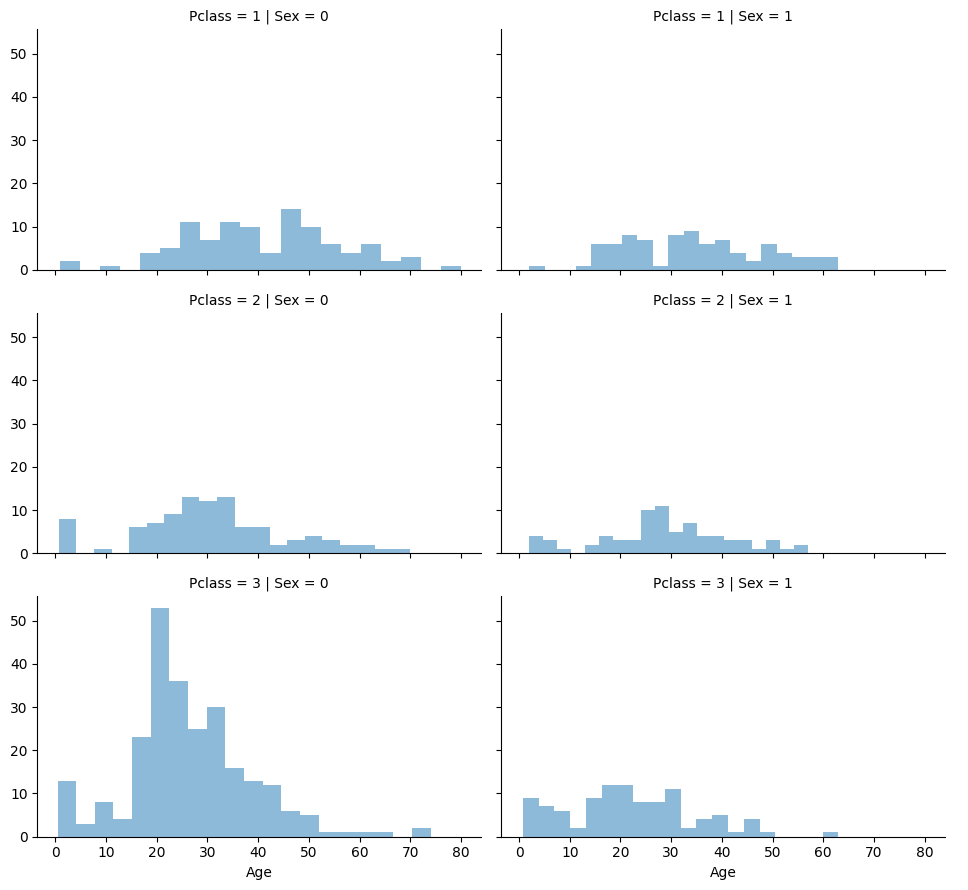

In [19]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Gender')
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

Let us start by preparing an empty array to contain guessed Age values based on Pclass x Gender combinations.

In [20]:
train_df[['Pclass', 'Title','Sex','Age']].groupby(['Pclass', 'Title','Sex'])['Age'].agg(['mean','count'])

mean  count
Pclass Title Sex                  
1      1     0    41.580460     87
       2     1    29.744681     47
       3     1    40.400000     35
       4     0     5.306667      3
       5     0    48.727273     11
             1    43.333333      3
2      1     0    32.768293     82
       2     1    22.560606     33
       3     1    33.682927     41
       4     0     2.258889      9
       5     0    42.000000      8
3      1     0    28.724891    229
       2     1    16.123188     69
       3     1    33.515152     33
       4     0     5.350833     24

In [21]:
guess_ages = np.zeros((5,3,2))
guess_ages

array([[[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]]])

Now we iterate over Sex (0 or 1) and Pclass (1, 2, 3) to calculate guessed values of Age for the six combinations.

In [22]:
for dataset in combine:
    for i in range(0, 5):
        for j in range(0, 3):
          for k in range(0,2):
            guess_df = dataset[(dataset['Title'] == i+1) & \
                                  (dataset['Pclass'] == j+1) & \
                                  (dataset['Sex'] == k)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()
            if (pd.isnull(age_guess)):
              age_guess = -1
            # Convert random age float to nearest .5 age
            guess_ages[i,j,k] = int( age_guess/0.5 + 0.5 ) * 0.5

    for i in range(0, 5):
        for j in range(0, 3):
          for k in range(0,2):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Title == i+1) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j,k]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Cabin_section
0,0,3,0,22,1,0,7.2500,S,1,0.0
1,1,1,1,38,1,0,71.2833,C,3,3.0
2,1,3,1,26,0,0,7.9250,S,2,0.0
3,1,1,1,35,1,0,53.1000,S,3,3.0
4,0,3,0,35,0,0,8.0500,S,1,0.0


Let us create Age bands and determine correlations with Survived.

In [23]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

<ipython-input-23-15bf441f7bc6>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)


,AgeBand,Survived
0,"(-0.08, 16.0]",0.592357
1,"(16.0, 32.0]",0.308725
2,"(32.0, 48.0]",0.388350
3,"(48.0, 64.0]",0.428571
4,"(64.0, 80.0]",0.090909


In [24]:
train_df['AgeBand'] = pd.qcut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

<ipython-input-24-1052fda705bd>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)


,AgeBand,Survived
0,"(-0.001, 18.0]",0.551020
1,"(18.0, 25.0]",0.333333
2,"(25.0, 30.0]",0.245000
3,"(30.0, 40.0]",0.413043
4,"(40.0, 80.0]",0.369128


In [25]:
# # STANDARDIZING AGE,FARE

# from sklearn.preprocessing import StandardScaler

# for dataset in [train_df]:
#     numerical_features = ['Age', 'Fare']
#     scaler = StandardScaler()
#     dataset[numerical_features] = scaler.fit_transform(dataset[numerical_features])

#  for dataset in [test_df]:
#     numerical_features = ['Age', 'Fare']
#     dataset[numerical_features] = scaler.transform(dataset[numerical_features])

Let us replace Age with ordinals based on these bands.

In [26]:
for dataset in combine:
    dataset.loc[ dataset['Age'] <= 16, 'Age_band_number'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age_band_number'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age_band_number'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age_band_number'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age_band_number'] = 4
    dataset['Age_band_number'] = dataset['Age_band_number'].astype(int)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Cabin_section,AgeBand,Age_band_number
0,0,3,0,22,1,0,7.2500,S,1,0.0,"(18.0, 25.0]",1
1,1,1,1,38,1,0,71.2833,C,3,3.0,"(30.0, 40.0]",2
2,1,3,1,26,0,0,7.9250,S,2,0.0,"(25.0, 30.0]",1
3,1,1,1,35,1,0,53.1000,S,3,3.0,"(30.0, 40.0]",2
4,0,3,0,35,0,0,8.0500,S,1,0.0,"(30.0, 40.0]",2


We can not remove the AgeBand feature.

In [27]:
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Cabin_section,Age_band_number
0,0,3,0,22,1,0,7.2500,S,1,0.0,1
1,1,1,1,38,1,0,71.2833,C,3,3.0,2
2,1,3,1,26,0,0,7.9250,S,2,0.0,1
3,1,1,1,35,1,0,53.1000,S,3,3.0,2
4,0,3,0,35,0,0,8.0500,S,1,0.0,2


### Create new feature combining existing features

We can create a new feature for FamilySize which combines Parch and SibSp. This will enable us to drop Parch and SibSp from our datasets.

In [28]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


We can create another feature called IsAlone.

In [29]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


Let us drop Parch, SibSp, and FamilySize features in favor of IsAlone.

In [30]:
# train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
# test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Cabin_section,Age_band_number,FamilySize,IsAlone
0,0,3,0,22,1,0,7.2500,S,1,0.0,1,2,0
1,1,1,1,38,1,0,71.2833,C,3,3.0,2,2,0
2,1,3,1,26,0,0,7.9250,S,2,0.0,1,1,1
3,1,1,1,35,1,0,53.1000,S,3,3.0,2,2,0
4,0,3,0,35,0,0,8.0500,S,1,0.0,2,1,1


We can also create an artificial feature combining Pclass and Age.

In [31]:
for dataset in combine:
    dataset['Age_band_number*Class'] = dataset.Age_band_number * dataset.Pclass

train_df.loc[:, ['Age_band_number*Class', 'Age_band_number', 'Pclass']].head(10)

,Age_band_number*Class,Age_band_number,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


### Completing a categorical feature

Embarked feature takes S, Q, C values based on port of embarkation. Our training dataset has two missing values. We simply fill these with the most common occurance.

In [32]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [33]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


### Converting categorical feature to numeric

We can now convert the EmbarkedFill feature by creating a new numeric Port feature.

In [34]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Cabin_section,Age_band_number,FamilySize,IsAlone,Age_band_number*Class
0,0,3,0,22,1,0,7.2500,0,1,0.0,1,2,0,3
1,1,1,1,38,1,0,71.2833,1,3,3.0,2,2,0,2
2,1,3,1,26,0,0,7.9250,0,2,0.0,1,1,1,3
3,1,1,1,35,1,0,53.1000,0,3,3.0,2,2,0,2
4,0,3,0,35,0,0,8.0500,0,1,0.0,2,1,1,6


### Quick completing and converting a numeric feature

We can now complete the Fare feature for single missing value in test dataset using mode to get the value that occurs most frequently for this feature. We do this in a single line of code.

Note that we are not creating an intermediate new feature or doing any further analysis for correlation to guess missing feature as we are replacing only a single value. The completion goal achieves desired requirement for model algorithm to operate on non-null values.

We may also want round off the fare to two decimals as it represents currency.

<Axes: ylabel='Fare'>

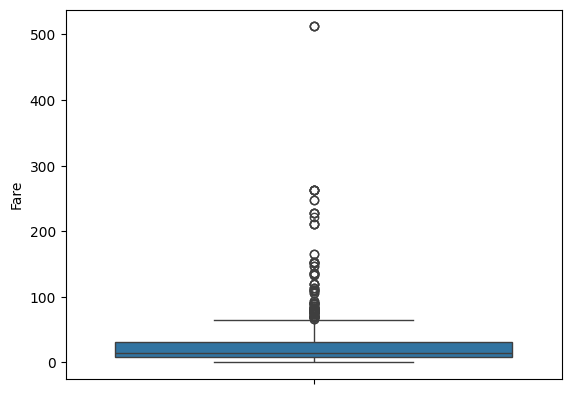

In [35]:
sns.boxplot(train_df['Fare'])

In [36]:
q1 = train_df["Fare"].quantile(0.25)
q2 = train_df["Fare"].quantile(0.75)
IQR = q2 - q1
lower_bound = q1 - 1.5 * IQR
upper_bound = q2 + 1.5 * IQR
print(lower_bound)
print(upper_bound)

-26.724
65.6344


In [37]:
train_df['Fare'] = train_df['Fare'].clip(upper=upper_bound)
test_df['Fare'] = test_df['Fare'].clip(upper=upper_bound)

In [38]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

<ipython-input-38-e290e000cf8e>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Cabin_section,Age_band_number,FamilySize,IsAlone,Age_band_number*Class
0,892,3,0,34,0,0,7.8292,2,1,0.0,2,1,1,6
1,893,3,1,47,1,0,7.0000,0,3,0.0,2,2,0,6
2,894,2,0,62,0,0,9.6875,2,1,0.0,3,1,1,6
3,895,3,0,27,0,0,8.6625,0,1,0.0,1,1,1,3
4,896,3,1,22,1,1,12.2875,0,3,0.0,1,3,0,3


We can not create FareBand.

In [39]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

<ipython-input-39-95f0d99ce732>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)


,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 65.634]",0.581081


Convert the Fare feature to ordinal values based on the FareBand.

In [40]:

train_df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Title', 'Cabin_section', 'Age_band_number', 'FamilySize',
       'IsAlone', 'Age_band_number*Class', 'FareBand'],
      dtype='object')

In [41]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare_band_number'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare_band_number'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare_band_number']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare_band_number'] = 3
    dataset['Fare_band_number'] = dataset['Fare_band_number'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]

train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Cabin_section,Age_band_number,FamilySize,IsAlone,Age_band_number*Class,Fare_band_number
0,0,3,0,22,1,0,7.2500,0,1,0.0,1,2,0,3,0
1,1,1,1,38,1,0,65.6344,1,3,3.0,2,2,0,2,3
2,1,3,1,26,0,0,7.9250,0,2,0.0,1,1,1,3,1
3,1,1,1,35,1,0,53.1000,0,3,3.0,2,2,0,2,3
4,0,3,0,35,0,0,8.0500,0,1,0.0,2,1,1,6,1
5,0,3,0,26,0,0,8.4583,2,1,0.0,1,1,1,3,1
6,0,1,0,54,0,0,51.8625,0,1,5.0,3,1,1,3,3
7,0,3,0,2,3,1,21.0750,0,4,0.0,0,5,0,0,2
8,1,3,1,27,0,2,11.1333,0,3,0.0,1,3,0,3,1
9,1,2,1,14,1,0,30.0708,1,3,0.0,0,2,0,0,2


And the test dataset.

In [42]:
test_df.head(5)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Cabin_section,Age_band_number,FamilySize,IsAlone,Age_band_number*Class,Fare_band_number
0,892,3,0,34,0,0,7.8292,2,1,0.0,2,1,1,6,0
1,893,3,1,47,1,0,7.0000,0,3,0.0,2,2,0,6,0
2,894,2,0,62,0,0,9.6875,2,1,0.0,3,1,1,6,1
3,895,3,0,27,0,0,8.6625,0,1,0.0,1,1,1,3,1
4,896,3,1,22,1,1,12.2875,0,3,0.0,1,3,0,3,1


In [43]:
# STANDARDIZING AGE,FARE

from sklearn.preprocessing import StandardScaler

for dataset in [train_df]:
      numerical_features = ['Age', 'Fare']
      scaler = StandardScaler()
      dataset[numerical_features] = scaler.fit_transform(dataset[numerical_features])

for dataset in [test_df]:
      numerical_features = ['Age', 'Fare']
      dataset[numerical_features] = scaler.transform(dataset[numerical_features])

In [44]:
train_df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Title', 'Cabin_section', 'Age_band_number', 'FamilySize',
       'IsAlone', 'Age_band_number*Class', 'Fare_band_number'],
      dtype='object')

In [45]:
for dataset in combine:
    dataset['FamilySize'] = dataset['FamilySize'].apply(lambda x: 7 if x > 7 else x)
    dataset['SibSp'] = dataset['SibSp'].apply(lambda x: 4 if x > 4 else x)
    dataset['Parch'] = dataset['Parch'].apply(lambda x: 3 if x > 3 else x)


In [46]:
# Weight of Evidence
def weight_of_evidence( feature, target):

# feature,target = 'Age_band_number','Survived'
  df_woe_iv = (pd.crosstab(train_df[feature],train_df[target],
                        normalize='columns')
              .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
              .assign(iv=lambda dfx: np.sum(dfx['woe']*
                                            (dfx[1]-dfx[0]))))
  print(df_woe_iv)

weight_of_evidence( 'Pclass', 'Survived')
weight_of_evidence( 'Sex', 'Survived')
weight_of_evidence( 'Embarked', 'Survived')
weight_of_evidence( 'Title', 'Survived')
weight_of_evidence( 'Cabin_section', 'Survived')
weight_of_evidence( 'Age_band_number', 'Survived')
weight_of_evidence( 'IsAlone', 'Survived')
weight_of_evidence( 'Fare_band_number', 'Survived')
weight_of_evidence( 'Age_band_number*Class', 'Survived')
# for dataset in combine:
#     dataset['FamilySize'] = dataset['FamilySize'].apply(lambda x: 7 if x > 7 else x)
#     dataset['SibSp'] = dataset['SibSp'].apply(lambda x: 4 if x > 4 else x)
#     dataset['Parch'] = dataset['Parch'].apply(lambda x: 3 if x > 3 else x)
weight_of_evidence( 'Parch', 'Survived')
weight_of_evidence( 'SibSp', 'Survived')
weight_of_evidence( 'FamilySize', 'Survived')
#STRONG PREDICTORS 0.3 to 0.5 -> Pclass, Sex, Title, Cabin Section, Fare band number
#MODERATE PREDICTORS 0.1 to 0.3-> Embarked, Age band number, IsAlone
# WEAK PREDICTORS 0.02 to 0.1 ->
#USELESS

Survived         0         1       woe       iv
Pclass                                         
1         0.145719  0.397661  1.003916  0.50095
2         0.176685  0.254386  0.364485  0.50095
3         0.677596  0.347953 -0.666483  0.50095
Survived         0         1       woe        iv
Sex                                             
0         0.852459  0.318713 -0.983833  1.341681
1         0.147541  0.681287  1.529877  1.341681
Survived         0         1       woe        iv
Embarked                                        
0         0.777778  0.640351 -0.194425  0.119923
1         0.136612  0.271930  0.688399  0.119923
2         0.085610  0.087719  0.024337  0.119923
Survived         0         1       woe        iv
Title                                           
1         0.794171  0.236842 -1.209905  1.522418
2         0.100182  0.380117  1.333489  1.522418
3         0.047359  0.292398  1.820361  1.522418
4         0.030965  0.067251  0.775569  1.522418
5         0.027322  0.023

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [47]:
train_df.isna().sum().sum()

0

In [48]:
#One hot encoding for  Title, Embarked (not for PClass because it is ordinal)

train_df = pd.get_dummies(train_df, columns=['Title','Embarked'])
test_df = pd.get_dummies(test_df, columns=['Title','Embarked'])

In [49]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape



((891, 20), (891,), (418, 20))

#Task 1


##Decision Tree

In [50]:
decision_tree = DecisionTreeClassifier(random_state = 1234319010)
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

98.77

In [51]:
from sklearn.model_selection import KFold, cross_val_score
kf = KFold(n_splits=5, shuffle=True, random_state=1234319010)
decision_tree = DecisionTreeClassifier(random_state=1234319010)
scores = cross_val_score(decision_tree, X_train, Y_train, cv=kf)
scores.mean()

0.7957127612830331

### Random search

In [99]:
#Random Search
from random import *
param_rand = {
    'max_depth': np.arange(3,15),
    'min_samples_split': np.arange(2, 15),
    'min_samples_leaf': np.arange(1, 15),
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2']
}
decision_tree = DecisionTreeClassifier(random_state = 1234319010)
random_search = RandomizedSearchCV(estimator = decision_tree, param_distributions=param_rand,n_iter=200, cv=5, random_state=1234319010)
random_search.fit(X_train, Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
335 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
335 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/uti

RandomizedSearchCV(cv=5,
                   estimator=DecisionTreeClassifier(random_state=1234319010),
                   n_iter=200,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
                   random_state=1234319010)

In [100]:
print(random_search.best_params_)
print(random_search.best_score_)

{'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'gini'}
0.8293892411022534


### Grid Search

In [192]:
#Grid Search
from sklearn.model_selection import *
param_grid = {
    'criterion' :['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6, 7, 8, 9],
    'min_samples_leaf': [1, 2, 5, 10],
    'min_samples_split': [5, 10, 12, 15],
    'max_features': ['auto', 'sqrt', 'log2']
}
decision_tree = DecisionTreeClassifier(random_state = 1234319010)
grid_search = GridSearchCV(estimator=decision_tree, param_grid=param_grid, cv=5)
grid_search.fit(X_train, Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1120 fits failed out of a total of 3360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1120 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/u

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1234319010),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [5, 10, 12, 15]})

In [193]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 15}
0.8327600276191074


###Hyperopt

In [158]:
#HyperOpt
# !pip install hyperopt
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
import numpy as np

space = {
    'max_depth': hp.choice('max_depth', list(np.arange(3, 15, dtype=int))),
    'min_samples_split': hp.choice('min_samples_split', list(np.arange(2, 15, dtype=int))),
    'min_samples_leaf': hp.choice('min_samples_leaf',list( np.arange(1, 15, dtype=int))),
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'max_features': hp.choice('max_features', ['sqrt', 'log2']),
}

# objective function
def objective(params):
    clf = DecisionTreeClassifier(**params,random_state=1234)
    clf.fit(X_train, Y_train)
    score = cross_val_score(clf, X_train, Y_train, cv=5, scoring='accuracy').mean()
    return {'loss': -score, 'status': STATUS_OK}

trials = Trials()

# optimization
best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=1000,
    trials=trials
)

# best parameters
print(best_params)

100%|██████████| 1000/1000 [01:16<00:00, 13.08trial/s, best loss: -0.8260372857949909]
{'criterion': 1, 'max_depth': 11, 'max_features': 0, 'min_samples_leaf': 2, 'min_samples_split': 7}


In [159]:
trials_results = pd.DataFrame([f['result'] for f in trials.trials])
trials_results.sort_values('loss', ascending=True).head()

,loss,status
842,-0.826037,ok
368,-0.826037,ok
804,-0.826037,ok
803,-0.826037,ok
802,-0.826037,ok


### Plot Best tree

In [165]:
best_decision_tree = DecisionTreeClassifier(random_state=1234319010,criterion = 'gini',max_depth=6, max_features = 'sqrt', min_samples_leaf =5, min_samples_split = 15)
best_decision_tree.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=6, max_features='sqrt', min_samples_leaf=5,
                       min_samples_split=15, random_state=1234319010)

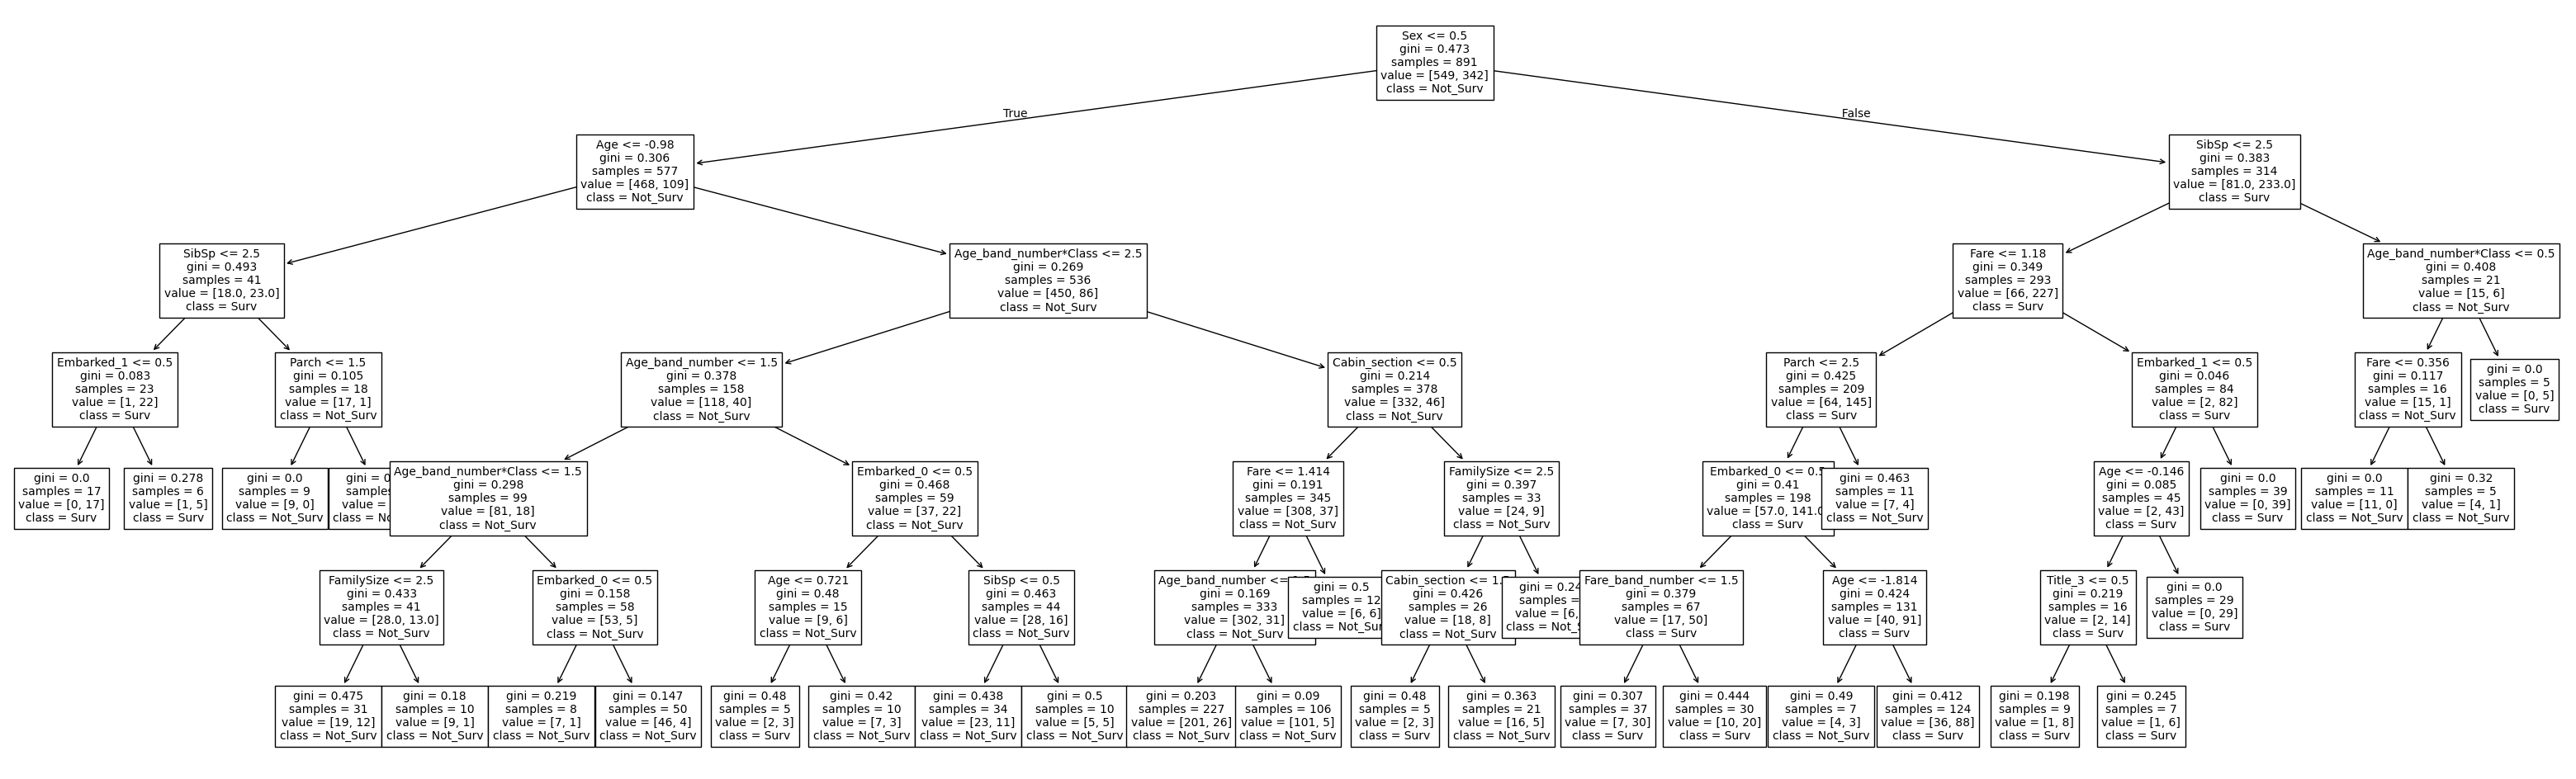

In [185]:
import matplotlib.pyplot as plt
from sklearn import tree
plt.figure(figsize=(40,12))
tree.plot_tree(best_decision_tree, fontsize =10, feature_names = X_train.columns,class_names=['Not_Surv','Surv'])
plt.show()

### Average Accuracy on 5CV

In [196]:
from sklearn.model_selection import KFold, cross_val_score
kf = KFold(n_splits=5, shuffle=True, random_state=1234319010)
best_decision_tree = DecisionTreeClassifier(random_state=1234319010,criterion = 'gini',max_depth=6, max_features = 'sqrt', min_samples_leaf =5, min_samples_split = 15)
scores = cross_val_score(best_decision_tree, X_train, Y_train, cv=kf)
scores.mean()

0.8125353085179837

## Random Forest

In [187]:
random_forest = RandomForestClassifier(n_estimators=100,random_state = 1234319010)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

98.77

### Random Search

In [202]:
#Random Search
param_rand = {"n_estimators": np.arange(100, 500, 20),
           "max_depth": np.arange(3,15),
           "min_samples_split": np.arange(2, 15),
           "min_samples_leaf": np.arange(1, 15),
           "max_features": ['auto', 'sqrt', 'log2'],
           "max_samples": np.arange(0.6,1.0,0.1)}


rf_tree = RandomForestClassifier(random_state = 1234319010)
random_search = RandomizedSearchCV(estimator = rf_tree, param_distributions=param_rand,n_iter=200, cv=5, random_state=1234319010)
random_search.fit(X_train, Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
345 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
345 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/uti

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(random_state=1234319010),
                   n_iter=200,
                   param_distributions={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'max_samples': array([0.6, 0.7, 0.8, 0.9]),
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'n_estimators': array([100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340,
       360, 380, 400, 420, 440, 460, 480])},
                   random_state=1234319010)

In [203]:
print(random_search.best_params_)
print(random_search.best_score_)

{'n_estimators': 120, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_samples': 0.6, 'max_features': 'sqrt', 'max_depth': 4}
0.8305065595380077


### Grid Search

In [211]:
#Grid Search
from sklearn.model_selection import *
param_grid = {
    'n_estimators': [100, 250, 500],
    'max_depth': [4, 5, 6, 7, 8],
    'min_samples_leaf': [2, 5, 10],
    'min_samples_split': [5, 10, 15],
    'criterion' :['gini'] ,
    'max_samples': [0.6, 0.8, 1.0]
}
rf_tree = RandomForestClassifier(random_state = 1234319010)
grid_search = GridSearchCV(estimator=rf_tree, param_grid=param_grid, cv=5,verbose=1)
grid_search.fit(X_train, Y_train)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234319010),
             param_grid={'criterion': ['gini'], 'max_depth': [4, 5, 6, 7, 8],
                         'max_samples': [0.6, 0.8, 1.0],
                         'min_samples_leaf': [2, 5, 10],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [100, 250, 500]},
             verbose=1)

In [212]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'criterion': 'gini', 'max_depth': 4, 'max_samples': 0.6, 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 100}
0.832741196409516


In [221]:
#Grid Search
from sklearn.model_selection import *
param_grid = {
    'n_estimators': [100],
    'max_depth': [8],
    'min_samples_leaf': [2],
    'min_samples_split': [15],
    'criterion' :['gini'] ,
    'max_samples': [0.6]
}
rf_tree = RandomForestClassifier(random_state = 1234319010)
grid_search = GridSearchCV(estimator=rf_tree, param_grid=param_grid, cv=5,verbose=1)
grid_search.fit(X_train, Y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'criterion': 'gini', 'max_depth': 8, 'max_samples': 0.6, 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 100}
0.8249011361496453


### HyperOpt

In [229]:
#HyperOpt
# !pip install hyperopt
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
import numpy as np

space = {
    'n_estimators': hp.choice('n_estimators',list(np.arange(100, 500, 20))),
    'max_depth': hp.choice('max_depth', list(np.arange(3, 15, dtype=int))),
    'min_samples_split': hp.choice('min_samples_split', list(np.arange(2, 15, dtype=int))),
    'min_samples_leaf': hp.choice('min_samples_leaf',list( np.arange(1, 15, dtype=int))),
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'max_features': hp.choice('max_features', ['sqrt']),
    'max_samples': hp.choice('max_samples', np.arange(0.6,1.0,0.1))
}

# objective function
def objective(params):
    clf = RandomForestClassifier(**params,random_state=1234)
    clf.fit(X_train, Y_train)
    score = cross_val_score(clf, X_train, Y_train, cv=5, scoring='accuracy').mean()
    return {'loss': -score, 'status': STATUS_OK}

trials = Trials()

# optimization
best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=400,
    trials=trials
)

# best parameters
print(best_params)
# criterion = 'gini',max_depth = 11, max_features = 'sqrt',min_samples_leaf = 1, min_samples_split = 4, n_estimators = 320

100%|██████████| 400/400 [25:20<00:00,  3.80s/trial, best loss: -0.8361245370660976]
{'criterion': 1, 'max_depth': 8, 'max_features': 0, 'max_samples': 3, 'min_samples_leaf': 0, 'min_samples_split': 2, 'n_estimators': 11}


In [214]:
trials_results = pd.DataFrame([f['result'] for f in trials.trials])
trials_results.sort_values('loss', ascending=True).head()

,loss,status
337,-0.831643,ok
262,-0.831643,ok
261,-0.831643,ok
260,-0.831643,ok
259,-0.831643,ok


 ### Best RF + KFold mean accuracy

In [230]:
from sklearn.model_selection import KFold, cross_val_score
kf = KFold(n_splits=5, shuffle=True, random_state=1234319010)
best_rf = RandomForestClassifier(random_state=1234,criterion = 'gini',max_depth = 11, max_features = 'sqrt',min_samples_leaf = 1, min_samples_split = 4, n_estimators = 320)
scores = cross_val_score(best_rf, X_train, Y_train, cv=kf)
scores.mean()

0.8260184545853996